
# RSCAM Computer Assessment 1


In this assessment you will use Python to solve some ordinary differential equations, to compute solutions numerically using discretization methods, to graph their solutions and to explore the behavior of differential equations and discretizations under changes in parameters.

Note that there are exercises embedded below, worth a total of 50 marks. After each exercise you will see a number in brackets that indicates the value of that exercise.

It is unlikely that you will complete the entire notebook in 2 hours.  Any remaining work can be done after the workshop.  Please check the learn web page for the assessment upload link and deadline.

After each graph that you produce you will wish to add a cell containing a brief comment. You are also asked to provide 'discussion' paragraphs in the notebook.  One way to do that is to use colour to highlight these observations, by embedding some markdown. "\<span style="color:blue">Observations: this is a comment.\<\/span\>".

At the start of any coding, we need a few commands to load relevant packages. We also introduce some abbreviations, "np" for numpy and "plt" for pyplot.

In [178]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Comparing Euler and Leapfrog Methods on the Trimer
Euler's method computes an approximate trajectory of a differential equation.  We can easily compute numerical solutions using Euler's method for any differential equation.  If we do this for several different stepsizes, we get different discrete approximations to the solution trajectory.  Another numerical method, which is particular good for conservative systems, is the leapfrog scheme.   Here you will compare the two methods by implementing them and simulating the dynamics of a simple model, the Lennard-Jones trimer.

## The Lennard-Jones Trimer
The LJ trimer is a model for a system of three atoms interacting through a pairwise Lennard-Jones potential. 
$$
\varphi_{\rm LJ}(r) = r^{-12} - r^{-6}.
$$
By considering special 'isosceles' configurations of the three atoms, we can simplify the equations for the LJ Trimer to a model with just two degrees of freedom, as mentioned in the slides of Lecture 1.

The Hamiltonian is then
$$ H = \frac{p_x^2}{4} + \frac{9p_y^2}{4} + 2\varphi_{\rm LJ}\left (\sqrt{x^2+y^2}\right ) + \varphi_{\rm LJ}(2x)$$.
The kinetic energy is $$K(p) = \frac{p_x^2}{4} + \frac{9p_y^2}{4}$$.   This is in the form $K(p) = p^T M^{-1} p/2$ where the mass matrix is $$M = {\rm diag}(2, 2/9)$$.   The potential energy function is $$U(q) = 2\varphi_{\rm LJ}\left (\sqrt{x^2+y^2} \right ) + \varphi_{\rm LJ}\left (2x \right)$$.

**Exercise 1a [2 marks]**: write out and then code the equations of motion of the trimer from the Hamiltonian.  In Python there is a distinction between row and column vectors.  We will use column vectors.   Let $q = [x, y]^T$ and $p=[p_x, p_y]^T$.  You will need to code a small function to compute the force which is the **negative gradient** of the potential energy function.  The input of the force function is a 2d column vector q and the output is a 2d column vector F.  A template is provided below for you to fill in.

In [179]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

x,y, p_x, p_y = sp.symbols('x y p_x p_y')
lj_rad = (sp.sqrt(x**2 + y**2))**(-12) - (sp.sqrt(x**2 + y**2))**(-6)
lj_hor = (2*x)**(-12) - (2*x)**(-6)
ke = (p_x**2)/4 + (9/4)*(p_y**2)
pe = 2*lj_rad + lj_hor
h = ke + pe

dx_dt_exp = sp.diff(ke,p_x)
dy_dt_exp = sp.diff(ke,p_y)
dp_x_dt_exp = -sp.diff(pe,x)
dp_y_dt_exp = -sp.diff(pe,y)

dx_dt = sp.lambdify((p_x),dx_dt_exp)
dy_dt = sp.lambdify((p_y),dy_dt_exp)
dp_x_dt = sp.lambdify((x,y),dp_x_dt_exp)
dp_y_dt = sp.lambdify((x,y),dp_y_dt_exp)
hamiltonian = sp.lambdify((x, y, p_x, p_y), h)


def calculate_force(position_vector):
    force_x = dp_x_dt(position_vector[0], position_vector[1])
    force_y = dp_y_dt(position_vector[0], position_vector[1])
    return [force_x,force_y]
    

Next, we need to code the two methods using the same calling sequence.  This way we can easily compare them.  

**Exercise 1b [2 marks]**: Write a function euler_step that takes a pair of input (column) vectors q and p, and a stepsize h, and produces an updated pair of vectors Q,P which are obtained by applying a single step of the Euler method.

In [180]:
def euler_step(q, p, h):
    q_x_new = q[0] + h*dx_dt(p[0])

    q_y_new = q[1] + h*dy_dt(p[1])

    p_x_new = p[0] + h*dp_x_dt(q[0], q[1])

    p_y_new = p[1] + h*dp_y_dt(q[0], q[1])

    q_new = [q_x_new, q_y_new]
    p_new = [p_x_new, p_y_new]
    return q_new, p_new


The final piece of the puzzle is a routine which computes a sequence of steps, with a given numerical method, starting from a given initial condition.  The resulting trajectory is stored in a pair of matrices QQ and PP, where the columns of QQ are the position vectors at the successive timesteps and the columns of PP are the momentum vectors at successive timesteps.

**Exercise 1c [2 marks]:** Write a function compute_trajectory which takes as inputs an initial position vector q0, an initial momentum vector p0, a stepsize h, a function one_step (in the form of the code for euler_step), a function force_field (in the form of the trimer_force routine given above, and a number of steps, N.  The output of this routine should be two matrices with N+1 columns and 2 rows, one for positions and one for momenta. The first column of the position array is the initial condition.  The n+1st column is the position vector after step n. 

In [181]:
def compute_trajectory(q_0, p_0, h, onestep, N):
    traj_matrix_q = np.zeros((2, N+1))
    traj_matrix_p = np.zeros((2, N+1))
    traj_matrix_q[:,0] = q_0
    traj_matrix_p[:,0] = p_0

    for j in range(1,N+1):
      current_step = [traj_matrix_q[:,(j-1)], traj_matrix_p[:,(j-1)]]
      q_new, p_new = onestep(current_step[0], current_step[1], h)
      traj_matrix_q[:,j] = q_new
      traj_matrix_p[:,j] = p_new

    return traj_matrix_q, traj_matrix_p

**Exercise 1d - accuracy comparisons [8 marks]:** implement the leapfrog method using the same approach as in Exercise 1b. 
For a system in the form $\dot{q} = p$, $\dot{p} = f(q)$, this method is given by
$$ \left| \begin{array}{rcl} 
p_{n+1/2}&:=&p_n + (h/2)\, f( q_n )\\
\qquad q_{n+1}&:=&q_n + h\, p_{n+1/2}\\
p_{n+1}&:=&p_{n+1/2} + (h/2)\, f( q_{n+1} )\\
\end{array}\right.$$
Using N steps of size h= 1/N, compare the accuracy of the two methods at time 1.   Use the same approach discussed in Lecture 3.  First produce an accurate "reference" or baseline solution using a very small stepsize (h=1e-5), then compare the results you obtain for larger stepsizes (1e-4, 1e-3, 1e-2) using each of the two methods.  You should consider different choices of the stepsize besides those mentioned in order to ensure that you see the asymptotic behavior for small stepsize).   All of the comparisons can be done at time 1.  **Use a loglog graph** to compare the error behaviors (where the x-axis is the stepsize in log scale and the y-axis is the error at time t=1).   Discuss the results (at most around 200 words are needed).

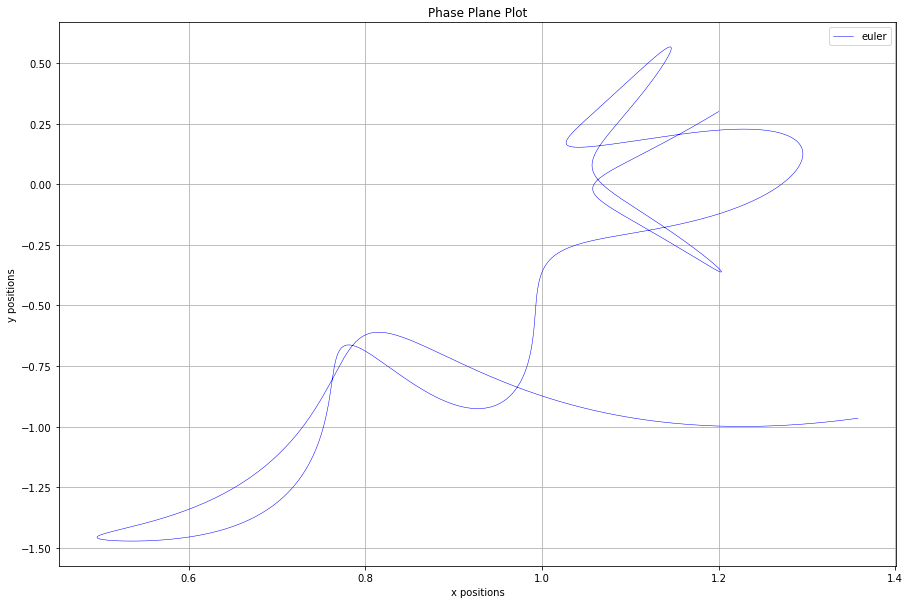

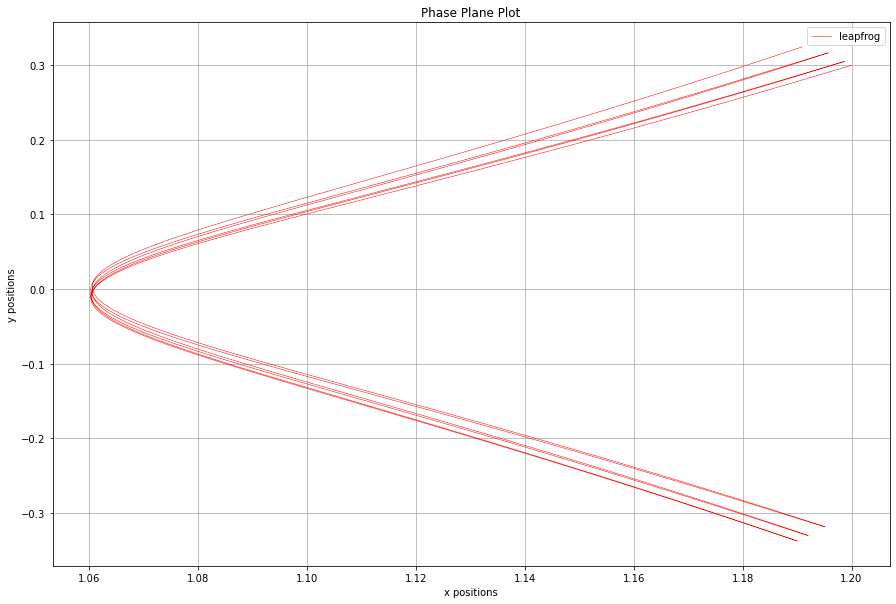

In [182]:
def leapfrog(q, p, h):
    p_x_half = p[0] + (h/2)*dp_x_dt(q[0], q[1])
    p_y_half = p[1] + (h/2)*dp_y_dt(q[0], q[1])
    q_x_new = q[0] + h * dx_dt(p_x_half)
    q_y_new = q[1] + h * dy_dt(p_y_half)
    p_x_new = p_x_half + h/2 * dp_x_dt(q_x_new, q_y_new)
    p_y_new = p_y_half + h/2 * dp_y_dt(q_x_new, q_y_new)
    q_new = [q_x_new, q_y_new]
    p_new = [p_x_new, p_y_new]
    return q_new, p_new

q_0 = [1.2,0.3]
p_0 = [0,0]
h = 0.01
N = 1000

euler_Q, euler_P = compute_trajectory(q_0, p_0, h, euler_step, N)
leapfrog_Q, leapfrog_P = compute_trajectory(q_0, p_0, h, leapfrog, N)

x_positions = euler_Q[0]
y_positions = euler_Q[1]

plt.figure(figsize=(15, 10)) 
plt.plot(x_positions, y_positions, linestyle='-', color='b',linewidth=0.5, label = "euler")
plt.title('Phase Plane Plot')
plt.xlabel('x positions')
plt.ylabel('y positions')
plt.grid(True)
plt.legend()

plt.show()

x_positions = leapfrog_Q[0]
y_positions = leapfrog_Q[1]

plt.figure(figsize=(15, 10)) 
plt.plot(x_positions, y_positions, linestyle='-', color='r',linewidth=0.5, label = "leapfrog")
plt.title('Phase Plane Plot')
plt.xlabel('x positions')
plt.ylabel('y positions')
plt.grid(True)
plt.legend()

plt.show()


<ipython-input-183-fbf3e786ebc7>:26: RuntimeWarning: divide by zero encountered in log
  log_leapfrog_e = [np.log(error) for error in leapfrog_e]


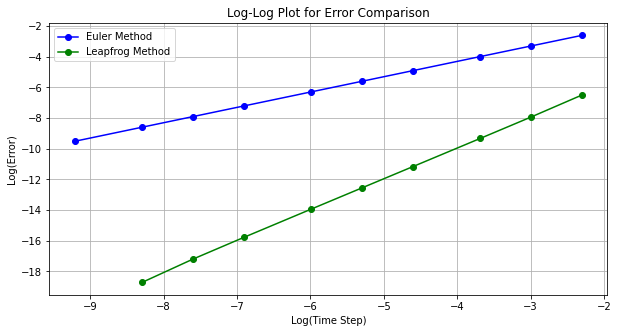

In [183]:
q_0 = [1.2,0.3]
p_0 = [0,0]
h = 0.0001
N = 10000

refQ, refP = compute_trajectory(q_0, p_0, h, leapfrog, N)

elements_list = [0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]

euler_e = []
leapfrog_e = []

for i,j in enumerate(elements_list):
    euler_Q, euler_P = compute_trajectory(q_0,p_0, j, euler_step, round(1/j))
    leapfrog_Q, leapfrog_P = compute_trajectory(q_0,p_0, j, leapfrog, round(1/j))
    euler_e.append(np.linalg.norm(refQ[:,N]-euler_Q[:,round(1/j)]))
    leapfrog_e.append(np.linalg.norm(refQ[:,N]-leapfrog_Q[:,round(1/j)]))





log_elements_list = [np.log(element) for element in elements_list]

log_euler_e = [np.log(error) for error in euler_e]
log_leapfrog_e = [np.log(error) for error in leapfrog_e]

plt.figure(figsize=(10, 5))
plt.plot(log_elements_list, log_euler_e, marker='o', label='Euler Method', color='blue')
plt.plot(log_elements_list, log_leapfrog_e, marker='o', label='Leapfrog Method', color='green')
plt.title('Log-Log Plot for Error Comparison')
plt.xlabel('Log(Time Step)')
plt.ylabel('Log(Error)')
plt.grid(True)
plt.legend()
plt.show()


    

## *Commentary*
### **It is clear from the graphs that the leapfrog method has a smaller mse error for smaller h. But as h gets larger, the errors of both methods get close to each other, that is, a larger step size is always unstable regardless of the method used. Notice how the gradient of the leapfrog is higher then euler: it is more sensitive to the step size used.**

**Exercise 1e - energy error comparisons [6 marks]:** Implement an energy function, trimer_energy, which computes the energy as a function of q and p.  You should ideally design this function so that you can pass the trajectory (QQ,PP) to the function and have it compute the energies at all the steps.   Compare the energy growth against time for the two methods (Euler, leapfrog).  In this case you should **graph the energy** as a function of time for each trajectory.  You may choose much larger ending times than t=1, for example t=10, t=100 etc.  Perform enough runs using different stepsizes to gain a good understanding of the energy behavior of each method.   Briefly discuss the graphs.


In [184]:
def trimer_energy(q, p):
    return hamiltonian(q[0], q[1], p[0], p[1])

def trimer_energy_traj(Q,P):
    energy = []
    for j in range (Q.shape[1]):
        energy.append(trimer_energy(Q[:,j], P[:,j]))

    return energy


    

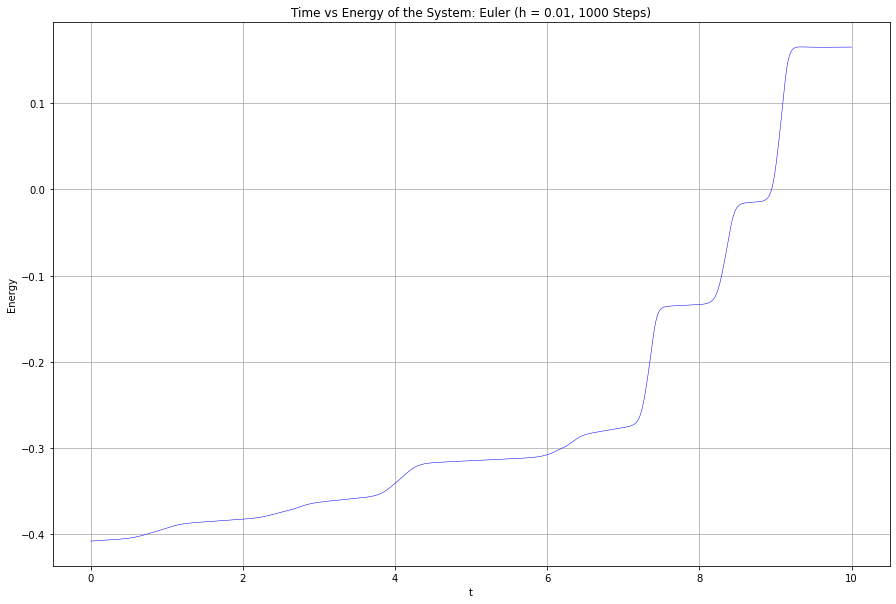

In [185]:
q_0 = [1.2,0.3]
p_0 = [0,0]
h = 0.01
N = 1000

euler_Q, euler_P = compute_trajectory(q_0, p_0, h, euler_step, N)

energy_euler = trimer_energy_traj(euler_Q,euler_P)



indices = [i * h for i in range(len(energy_euler))]

plt.figure(figsize=(15, 10))  

plt.plot(indices, energy_euler, linestyle='-', color='b', linewidth=0.5,label='Euler')

plt.title('Time vs Energy of the System: Euler (h = 0.01, 1000 Steps)')
plt.xlabel('t')
plt.ylabel('Energy')
plt.grid(True)

plt.show()

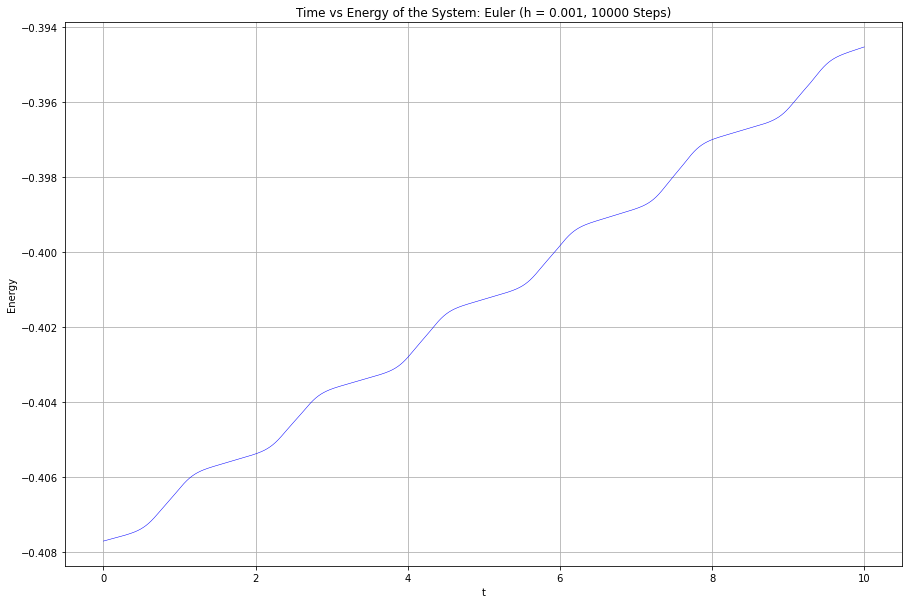

In [186]:
q_0 = [1.2,0.3]
p_0 = [0,0]
h = 0.001
N = 10000

euler_Q, euler_P = compute_trajectory(q_0, p_0, h, euler_step, N)

energy_euler = trimer_energy_traj(euler_Q,euler_P)



indices = [i * h for i in range(len(energy_euler))]

plt.figure(figsize=(15, 10))  

plt.plot(indices, energy_euler, linestyle='-', color='b', linewidth=0.5,label='Euler')

plt.title('Time vs Energy of the System: Euler (h = 0.001, 10000 Steps)')
plt.xlabel('t')
plt.ylabel('Energy')
plt.grid(True)

plt.show()

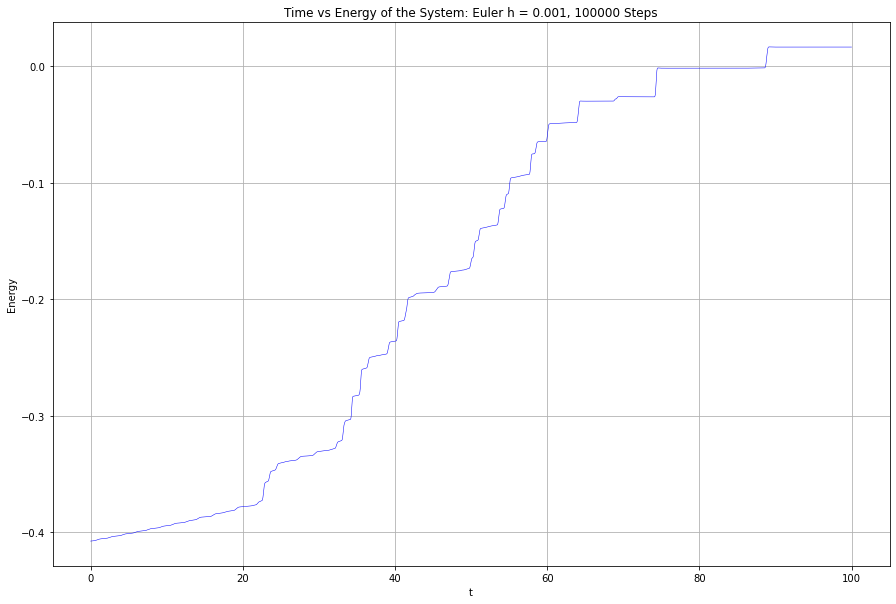

In [187]:
q_0 = [1.2,0.3]
p_0 = [0,0]
h = 0.001
N = 100000

euler_Q, euler_P = compute_trajectory(q_0, p_0, h, euler_step, N)

energy_euler = trimer_energy_traj(euler_Q,euler_P)



indices = [i * h for i in range(len(energy_euler))]

plt.figure(figsize=(15, 10))  

plt.plot(indices, energy_euler, linestyle='-', color='b', linewidth=0.5,label='Euler')

plt.title('Time vs Energy of the System: Euler h = 0.001, 100000 Steps')
plt.xlabel('t')
plt.ylabel('Energy')
plt.grid(True)

plt.show()

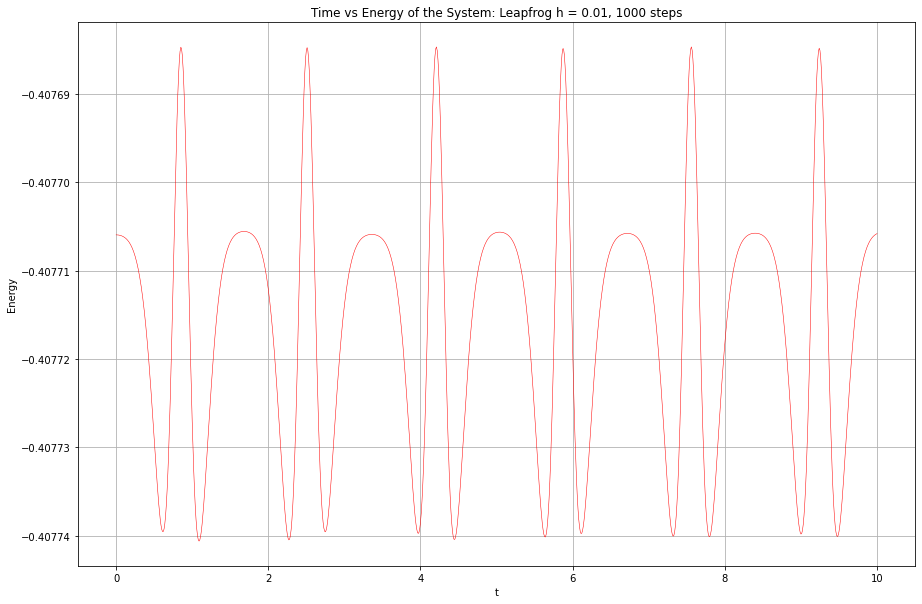

In [188]:
q_0 = [1.2,0.3]
p_0 = [0,0]
h = 0.01
N = 1000

leapfrog_Q, leapfrog_P = compute_trajectory(q_0, p_0, h, leapfrog, N)

energy_leapfrog = trimer_energy_traj(leapfrog_Q,leapfrog_P)



indices = [i * h for i in range(len(energy_leapfrog))]

plt.figure(figsize=(15, 10)) 

plt.plot(indices, energy_leapfrog, linestyle='-', color='r', linewidth=0.5,label='Leapfrog')

plt.title('Time vs Energy of the System: Leapfrog h = 0.01, 1000 steps')
plt.xlabel('t')
plt.ylabel('Energy')
plt.grid(True)

plt.show()

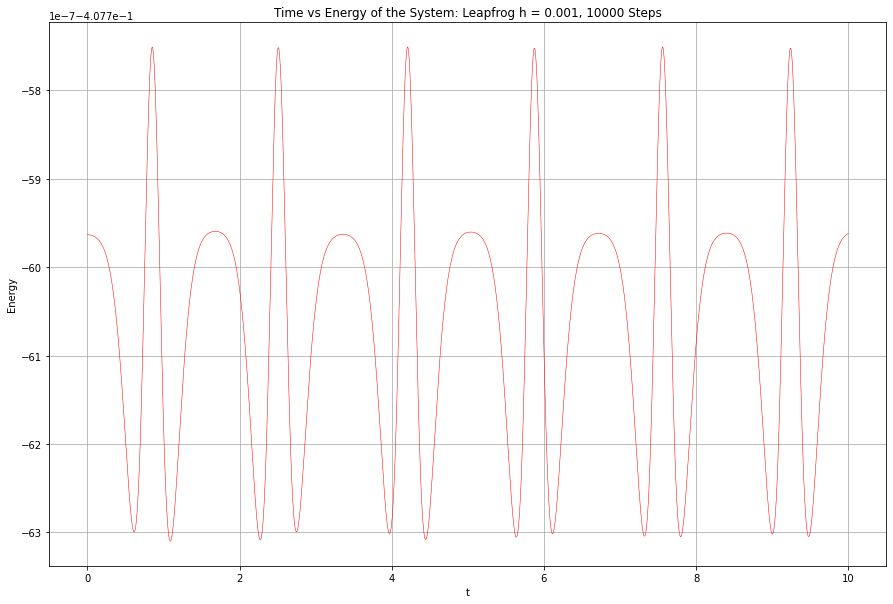

In [189]:
q_0 = [1.2,0.3]
p_0 = [0,0]
h = 0.001
N = 10000

leapfrog_Q, leapfrog_P = compute_trajectory(q_0, p_0, h, leapfrog, N)

energy_leapfrog = trimer_energy_traj(leapfrog_Q,leapfrog_P)



indices = [i * h for i in range(len(energy_leapfrog))]

plt.figure(figsize=(15, 10))  

plt.plot(indices, energy_leapfrog, linestyle='-', color='r', linewidth=0.5,label='Leapfrog')

plt.title('Time vs Energy of the System: Leapfrog h = 0.001, 10000 Steps')
plt.xlabel('t')
plt.ylabel('Energy')
plt.grid(True)

plt.show()

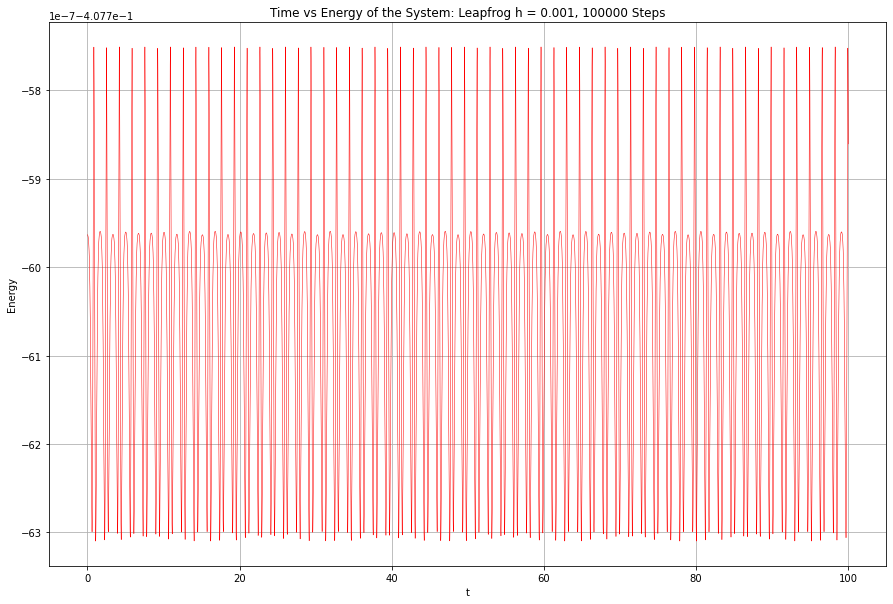

In [190]:
q_0 = [1.2,0.3]
p_0 = [0,0]
h = 0.001
N = 100000

leapfrog_Q, leapfrog_P = compute_trajectory(q_0, p_0, h, leapfrog, N)

energy_leapfrog = trimer_energy_traj(leapfrog_Q,leapfrog_P)



indices = [i * h for i in range(len(energy_leapfrog))]

plt.figure(figsize=(15, 10))  

plt.plot(indices, energy_leapfrog, linestyle='-', color='r', linewidth=0.5)

plt.title('Time vs Energy of the System: Leapfrog h = 0.001, 100000 Steps')
plt.xlabel('t')
plt.ylabel('Energy')
plt.grid(True)

plt.show()

## *Commentary*
### **We can clearly observe that all else equal, the leapfrog energy oscillates between a fixed value, whereas euler is unbounded. Depending on the initial condition used, euler will always be monotonically increasing or decreasing. Furthermore, we can observe that a smaller h will result in a smaller deviation from the hamiltonian for both methods. Increasing N while using the same stepsize will not affect leapfrog that much (since its oscillating), but since euler is unstable, the energy will increase/decrease more as we observe for longer periods.**


# Twin Pendulum

In this exercise you will modify the python code to compute solutions of a system of two particles moving in the plane. The particles will each be connected to the origin by a spring with rest length.  The particles also interact in a spring potential.

We think of our position vector $q$ as holding the position data for the whole system, so $q=[q_1,q_2]=[q_{1,x},q_{1,y},q_{2,x},q_{2,y}]$, and, similarly, $p$ is a vector in $\bf{R}^4$. We can write the new energy function as $$ H(q,p) = \| p_1 \|^2/2 + \| p_2 \|^2/2 + \omega_1^2(\|q_1\|-1)^2+ \omega_2^2(\|q_2\|-1)^2 + \epsilon \|q_1-q_2\|^2/2$$
Here $\omega_1,\omega_2$ are the frequencies of two nonlinear oscillators and $eps$ is the coupling coefficient.

**Exercise 2a [6]:**
Define new functions  `twinpend_energy` and `twinpend_force` using the trimer functions as models.  You do not need to compare the Euler and leapfrog methods in this example, **just use the leapfrog scheme.**

In [191]:
q_1_x,q_1_y, q_2_x, q_2_y, p_1_x, p_1_y, p_2_x, p_2_y, w_1, w_2, e = sp.symbols('q_1_x q_1_y q_2_x q_2_y p_1_x p_1_y p_2_x p_2_y w_1 w_2 e')

eq_1 = (p_1_x**2 + p_1_y**2) / 2
eq_2 = (p_2_x**2 + p_2_y**2) / 2
eq_3 = (w_1**2)*((sp.sqrt(q_1_x**2 + q_1_y**2) - 1)**2)
eq_4 = (w_2**2)*((sp.sqrt(q_2_x**2 + q_2_y**2) - 1)**2)
eq_5 = (e)*((q_1_x - q_2_x)**2 + (q_1_y - q_2_y)**2)/2

h = eq_1 + eq_2 + eq_3 + eq_4 + eq_5
e_1 = eq_1 + eq_3
e_2 = eq_2 + eq_4


dq_1_x_dt_exp = sp.diff(h,p_1_x)
dq_1_y_dt_exp = sp.diff(h,p_1_y)
dq_2_x_dt_exp = sp.diff(h,p_2_x)
dq_2_y_dt_exp = sp.diff(h,p_2_y)
dp_1_x_dt_exp = -sp.diff(h,q_1_x)
dp_1_y_dt_exp = -sp.diff(h,q_1_y)
dp_2_x_dt_exp = -sp.diff(h,q_2_x)
dp_2_y_dt_exp = -sp.diff(h,q_2_y)


dq_1_x_dt = sp.lambdify((p_1_x),dq_1_x_dt_exp)
dq_1_y_dt = sp.lambdify((p_1_y),dq_1_y_dt_exp)
dq_2_x_dt = sp.lambdify((p_2_x),dq_2_x_dt_exp)
dq_2_y_dt = sp.lambdify((p_2_y),dq_2_y_dt_exp)
dp_1_x_dt = sp.lambdify((e, w_1, q_2_x, q_1_x, q_1_y),dp_1_x_dt_exp)
dp_1_y_dt = sp.lambdify((e, w_1, q_2_y, q_1_x, q_1_y),dp_1_y_dt_exp)
dp_2_x_dt = sp.lambdify((e, w_2, q_1_x, q_2_x, q_2_y),dp_2_x_dt_exp)
dp_2_y_dt = sp.lambdify((e, w_2, q_1_y, q_2_x, q_2_y),dp_2_y_dt_exp)
hamiltonian = sp.lambdify((e, w_1, w_2, q_1_x, q_1_y, q_2_x, q_2_y, p_1_x, p_1_y, p_2_x, p_2_y),h)
energy_1 = sp.lambdify((w_1, q_1_x, q_1_y, p_1_x, p_1_y),e_1)
energy_2 = sp.lambdify((w_2, q_2_x, q_2_y, p_2_x, p_2_y),e_2)

    


In [192]:
def energy_twin(e,w_1, w_2, q1, q2, p1, p2, type = "total"):
    if type != "total":
       return energy_1(w_1,q1[0],q1[1], p1[0],p1[1]), energy_2(w_2,q2[0],q2[1], p2[0],p2[1]), hamiltonian(e, w_1, w_2, q1[0], q1[1], q2[0], q2[1], p1[0], p1[1], p2[0], p2[1])
    return hamiltonian(e, w_1, w_2, q1[0], q1[1], q2[0], q2[1], p1[0], p1[1], p2[0], p2[1])


def twin_energy_traj(e,w1,w2,Q1,Q2,P1,P2, type = "total"):
      
      if type != "total":
          energy_1, energy_2, energy_total = [],[],[]
          for j in range (Q1.shape[1]):
              energy_1_new, energy_2_new, energy_total_new = energy_twin(e,w1,w2,Q1[:,j],Q2[:,j],P1[:,j],P2[:,j], "seperate")
              energy_1.append(energy_1_new)
              energy_2.append(energy_2_new)
              energy_total.append(energy_total_new)

          return energy_1, energy_2, energy_total
      
      energy = []
      for j in range (Q1.shape[1]):
        energy.append(energy_twin(e,w1,w2,Q1[:,j],Q2[:,j],P1[:,j],P2[:,j]))

      return energy

In [193]:
def leapfrog_twin(q_1, q_2, p_1, p_2, h, e, w_1, w_2):
    p_1_x_half = p_1[0] + (h/2)*dp_1_x_dt(e,w_1,q_2[0], q_1[0], q_1[1])
    p_1_y_half = p_1[1] + (h/2)*dp_1_y_dt(e,w_1,q_2[1], q_1[0], q_1[1])
    p_2_x_half = p_2[0] + (h/2)*dp_2_x_dt(e,w_2,q_1[0], q_2[0], q_2[1])
    p_2_y_half = p_2[1] + (h/2)*dp_2_y_dt(e,w_2,q_1[1], q_2[0], q_2[1])
    q_1_x_new = q_1[0] + h * dq_1_x_dt(p_1_x_half)
    q_1_y_new = q_1[1] + h * dq_1_y_dt(p_1_y_half)
    q_2_x_new = q_2[0] + h * dq_2_x_dt(p_2_x_half)
    q_2_y_new = q_2[1] + h * dq_2_y_dt(p_2_y_half)
    p_1_x_new = p_1_x_half + h/2 * dp_1_x_dt(e,w_1,q_2_x_new, q_1_x_new, q_1_y_new)
    p_1_y_new = p_1_y_half + h/2 * dp_1_y_dt(e,w_1,q_2_y_new, q_1_x_new, q_1_y_new)
    p_2_x_new = p_2_x_half + h/2 * dp_2_x_dt(e,w_2,q_1_x_new, q_2_x_new, q_2_y_new)
    p_2_y_new = p_2_y_half + h/2 * dp_2_y_dt(e,w_2,q_1_y_new, q_2_x_new, q_2_y_new)


    q_1_new = [q_1_x_new, q_1_y_new]
    q_2_new = [q_2_x_new, q_2_y_new]
    p_1_new = [p_1_x_new, p_1_y_new]
    p_2_new = [p_2_x_new, p_2_y_new]

    return q_1_new, q_2_new, p_1_new, p_2_new

In [194]:

def compute_trajectory_twin(w1,w2,e,h,N,q10, q20, p10, p20):
    traj_matrix_q1 = np.zeros((2, N+1))
    traj_matrix_q2 = np.zeros((2, N+1))
    traj_matrix_p1 = np.zeros((2, N+1))
    traj_matrix_p2 = np.zeros((2, N+1))

    traj_matrix_q1[:,0] = q10
    traj_matrix_q2[:,0] = q20
    traj_matrix_p1[:,0] = p10
    traj_matrix_p2[:,0] = p20


    for j in range(1,N+1):
      current_step = [traj_matrix_q1[:,(j-1)], traj_matrix_q2[:,(j-1)], traj_matrix_p1[:,(j-1)],traj_matrix_p2[:,(j-1)]]
      q1_new, q2_new, p1_new, p2_new = leapfrog_twin(*current_step, h,e,w1,w2)
      traj_matrix_q1[:,j], traj_matrix_q2[:,j] = q1_new, q2_new
      traj_matrix_p1[:,j], traj_matrix_p2[:,j] = p1_new, p2_new

    return traj_matrix_q1, traj_matrix_q2, traj_matrix_p1, traj_matrix_p2






**Exercise 2b [6]:**
Set the constants $\omega_1,\omega_2$ equal to one.  Set $\epsilon=0.1$ to represent a moderate coupling.  Take as initial condition $q_0 = [0,1,0,1]^T$ and $p_0 = [1,-1,1,1]^T$.  You will need to experiment a little: choose the stepsize by trial and error to get an accurate approximation of the true motion, but bear in mind the need to use a relatively large stepsize (e.g. $h=0.1$) in order to compute a reasonably long-term evolution of the system. Plot the trajectories of the two particles in the $(x,y)$ plane, on the same axes, with a separate curve for each particle.  Separately, plot the energy as a function of time.  

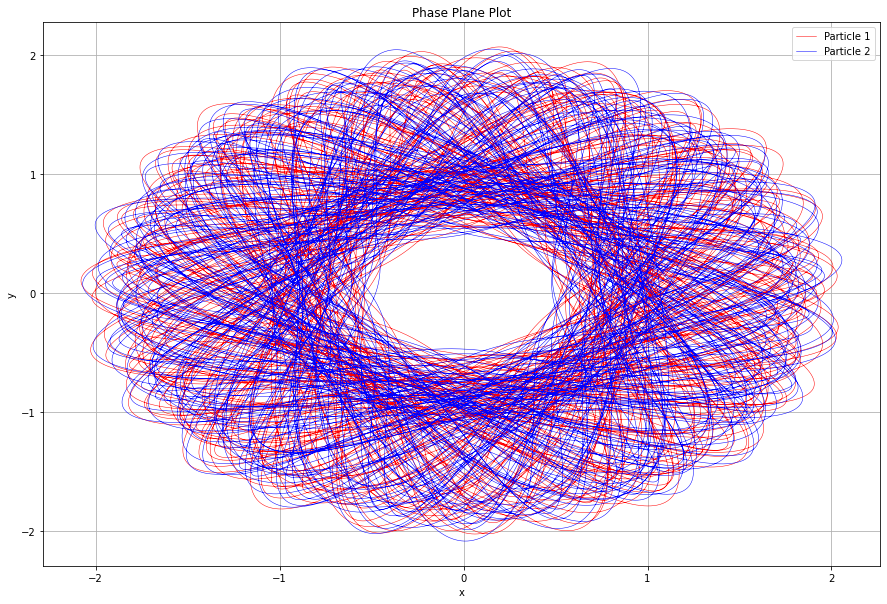

In [195]:
q1 = [0,1]
q2 = [0,1]
p1 = [1,-1]
p2 = [1,1]
h = 0.01
N=100000
e = 0.1
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

plt.figure(figsize=(15, 10)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5, label = "Particle 1")
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5, label = "Particle 2")
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()

plt.show()



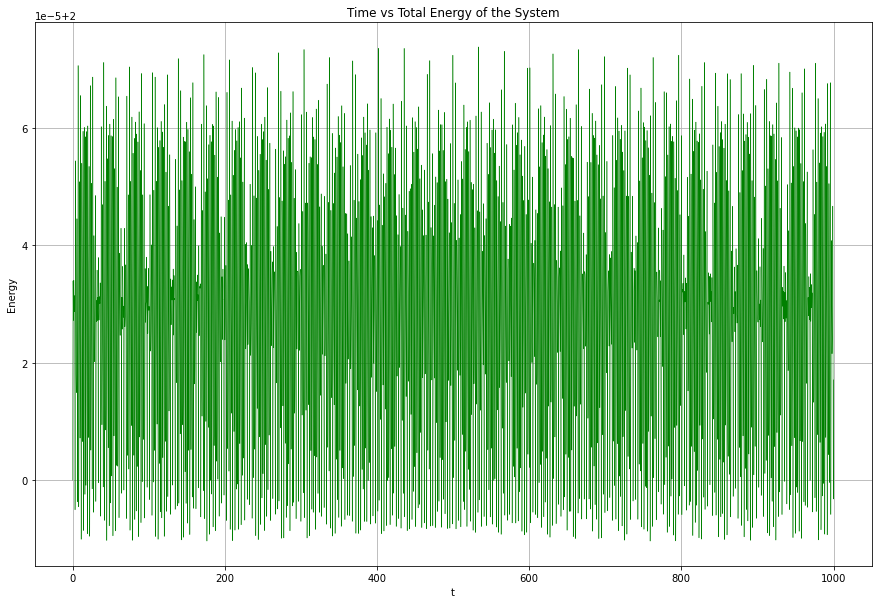

In [196]:

energy_vector = twin_energy_traj(e,w_1,w_2,twin_Q1, twin_Q2, twin_P1,twin_P2)

indices = [i * h for i in range(len(energy_vector))]

plt.figure(figsize=(15, 10))  

plt.plot(indices, energy_vector, linestyle='-', color='g', linewidth=0.5)

plt.title('Time vs Total Energy of the System')
plt.xlabel('t')
plt.ylabel('Energy')
plt.grid(True)


plt.show()







**Exercise 2c - evaluation and discussion [8]:**
Using graphs and text, explore the motion of the twin pendulum system.    
Are the solutions periodic?  Bounded?  Is this  a chaotic dynamical system?  
Conduct further experiments to understand the system: what happens when you start them with different intial conditions?  With high velocities?  How does the choice of stepsize alter the behavior you observe?   Your answer for this part should comprise about one paragraph  (at most around 250 words) of English text, with a few graphs, all incorporated as markup in your jupyter notebook.

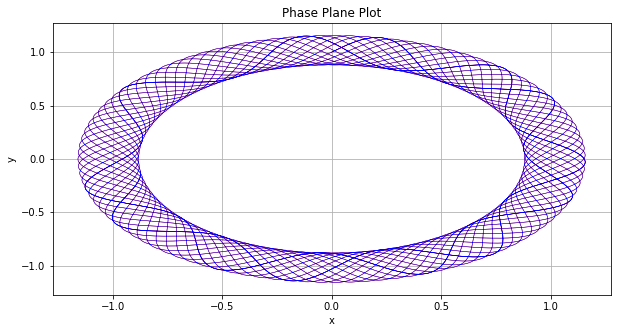

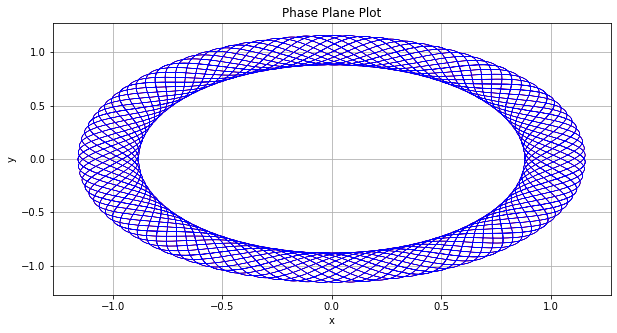

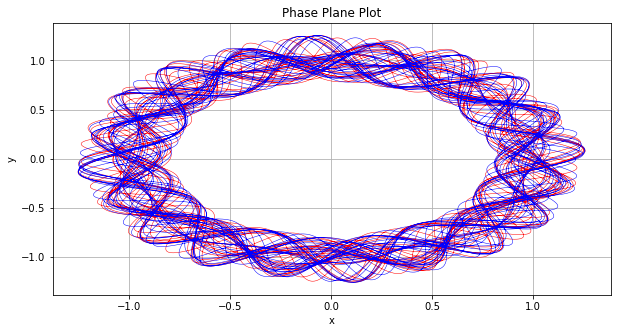

In [197]:
q1 = [0,1]
q2 = [0,1]
p1 = [0.2,0.2]
p2 = [0.2,0.2]
h = 0.01
N=50000
e = 0.1
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

plt.figure(figsize=(10, 5)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.show()


q1 = [0,1]
q2 = [0,1]
p1 = [0.2,0.2]
p2 = [0.2,0.2]
h = 0.01
N=100000
e = 0.1
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

plt.figure(figsize=(10, 5)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.show()

q1 = [0.1,1.1]
q2 = [-0.1,0.9]
p1 = [0.2,0.2]
p2 = [0.2,0.2]
h = 0.01
N=100000
e = 0.1
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

plt.figure(figsize=(10, 5)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.show()


## *Comments:*
### **For same and small initial position and velocity, the system seems periodic (first 2 plots). However a small change in the positions results in a completely different dynamic (the last plot), which suggests chaotic behavior since the system is sensitive to small perturbations.**


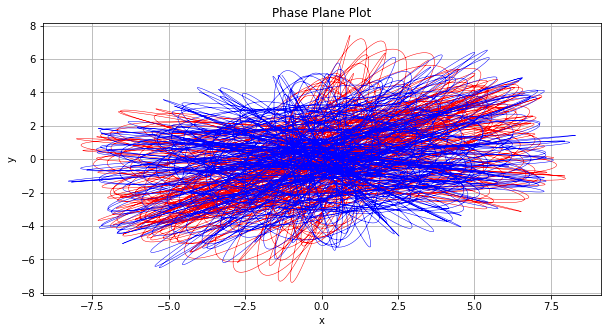

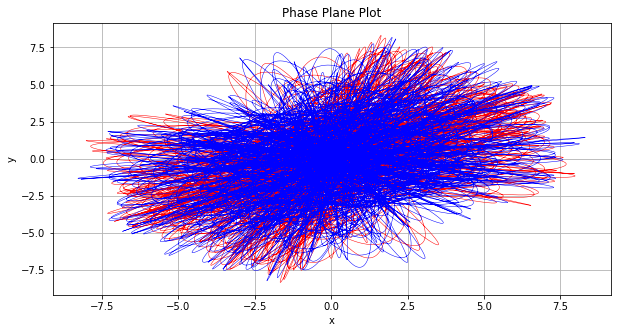

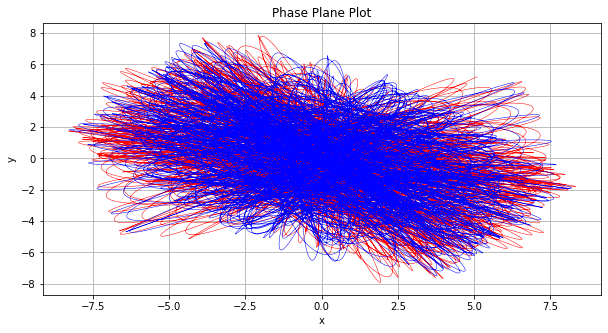

In [198]:
q1 = [5,5]
q2 = [-4,4]
p1 = [0.1,0.2]
p2 = [0.1,0.2]
h = 0.01
N=50000
e = 0.1
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

# Get x and y positions from the matrix
x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

# Create a phase plane plot
plt.figure(figsize=(10, 5)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

# Display the plot
plt.show()


q1 = [5,5]
q2 = [-4,4]
p1 = [0.1,0.2]
p2 = [0.1,0.2]
h = 0.01
N=100000
e = 0.1
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

# Get x and y positions from the matrix
x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

# Create a phase plane plot
plt.figure(figsize=(10, 5)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

# Display the plot
plt.show()

q1 = [5.1,5.2]
q2 = [-4.1,3.9]
p1 = [0.1,0.2]
p2 = [0.1,0.2]
h = 0.01
N=100000
e = 0.1
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

# Get x and y positions from the matrix
x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

# Create a phase plane plot
plt.figure(figsize=(10, 5)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

# Display the plot
plt.show()


## *Comments:* 
### **We can see that the periodic behavior is not present by looking at the first 2 graphs (they do not seem exactly the same although they are similar). So the 2 particles are less likely to form periodic motion when they dont start at aligned positions. Again, we can see the effect of perturbations on the 3rd graph, suggesting chaotic behavior.**

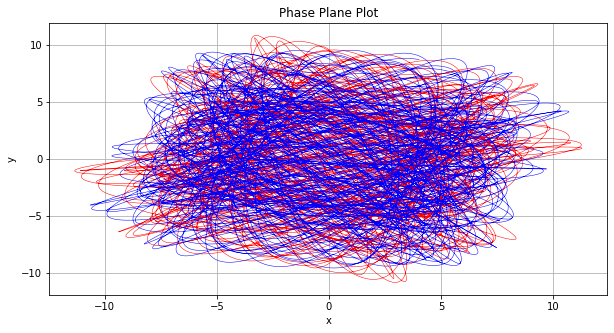

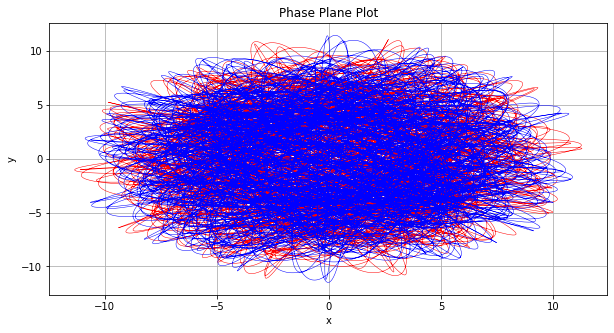

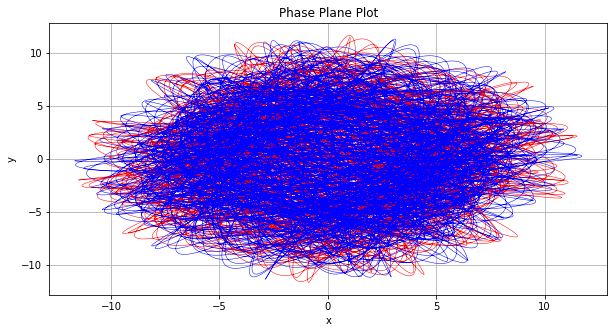

In [199]:
q1 = [5,-5]
q2 = [3,4]
p1 = [9,-7]
p2 = [7,3]
h = 0.01
N=50000
e = 0.1
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

# Get x and y positions from the matrix
x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

# Create a phase plane plot
plt.figure(figsize=(10, 5)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

# Display the plot
plt.show()


q1 = [5,-5]
q2 = [3,4]
p1 = [9,-7]
p2 = [7,3]
h = 0.01
N=100000
e = 0.1
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

# Get x and y positions from the matrix
x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

# Create a phase plane plot
plt.figure(figsize=(10, 5)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

# Display the plot
plt.show()

q1 = [5.3,-5.1]
q2 = [3.3,4]
p1 = [9.4,-7.4]
p2 = [7.1,3.4]
h = 0.01
N=100000
e = 0.1
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

# Get x and y positions from the matrix
x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

# Create a phase plane plot
plt.figure(figsize=(10, 5)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

# Display the plot
plt.show()

## *Comments:* 
### **We can say that we observe chaotic solutions for random, non-aligned initial conditions, especially for higher velocities.**

**Exercise 2d - energy conservation and adiabatic separation at long times [10]:**
In this exercise you will explore the conservation of total energy and the exchange of energy between two coupled pendula.  This related to the concept of adiabatic separation which plays an important role in physical models.

Define two energies by $E_1 = \| p_1 \|^2/2 + \omega_1^2(\|q_1\|-1)^2$ and $E_2 = \| p_2 \|^2/2 + \omega_2^2(\|q_2\|-1)^2$. Note that the total energy in the twin pendulum system is the sum of $E_1$ and $E_2$ plus the coupling term $\epsilon \|q_1-q_2\|^2/2$.  Create a function that takes QQ and PP and outputs arrays $E_1$, $E_2$ and $E$ which contain the corresponding energies at each step.

Set $\omega_1=\omega_2=1$ and $\epsilon =.1$.   Starting with the initial condition $q_0 = [0,-1,0,-1]^T$, $p_0 =[10,1,0,0]^T$, compute trajectories of the system and graph the trajectories in the $xy$-plane (separate curves for each particle). Use a stepsize $h=0.01$ and integrate for 1e5 steps.  Separately, plot the energies $E_1$ and $E_2$ over time.  Clearly the first subsystem starts with a higher initial energy than the second one ($E_1>>E_2$), but you should see that the energy gets exchanged rapidly between the two systems.  Despite this, you should also see that the total energy is well conserved, even when the time interval is fairly long.

Now consider the behavior of the system as $h$ is changed from $h=0.01$ to $h=0.1$, with all other parameters the same as before (N=1e5 steps).  (You can explore what happens when N is increased even further, if your computer is powerful enough!)  You should observe that the energy is no longer well conserved.  How does the total energy conservation depend on the stepsize, all other things being constant?

Try decreasing $\epsilon$ to 0.01 (reducing the strength of the coupling) and repeat your tests.    How does the strength of the coupling effect the results?

You may wish to explore what happens as you make the second frequency larger: $\omega_2=10$.

Your answer to this exercise should be around 500 words, maximum, supplemented by a few graphs.

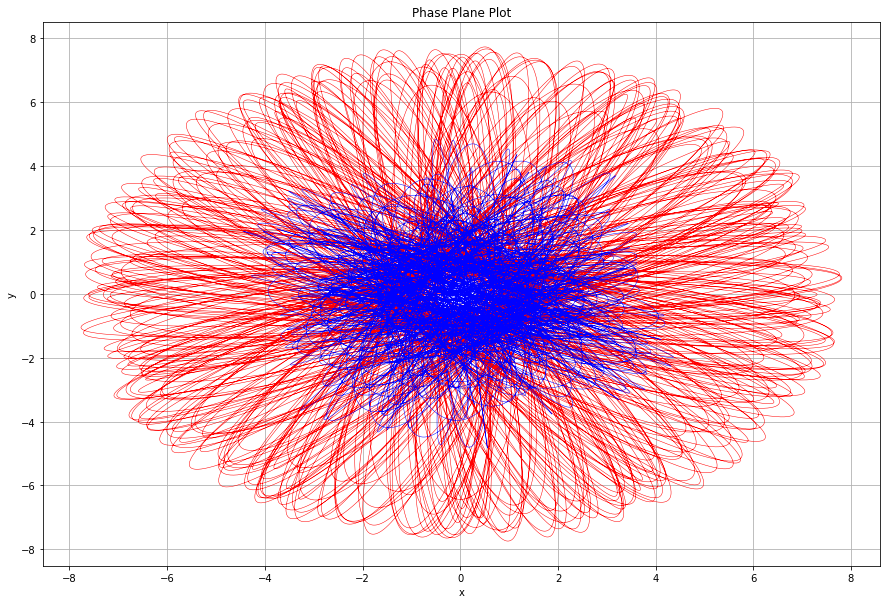

In [200]:
q1 = [0,-1]
q2 = [0,-1]
p1 = [10,1]
p2 = [0,0]
h = 0.01
N=100000
e = 0.1
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

# Get x and y positions from the matrix
x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

# Create a phase plane plot
plt.figure(figsize=(15, 10)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

# Display the plot
plt.show()


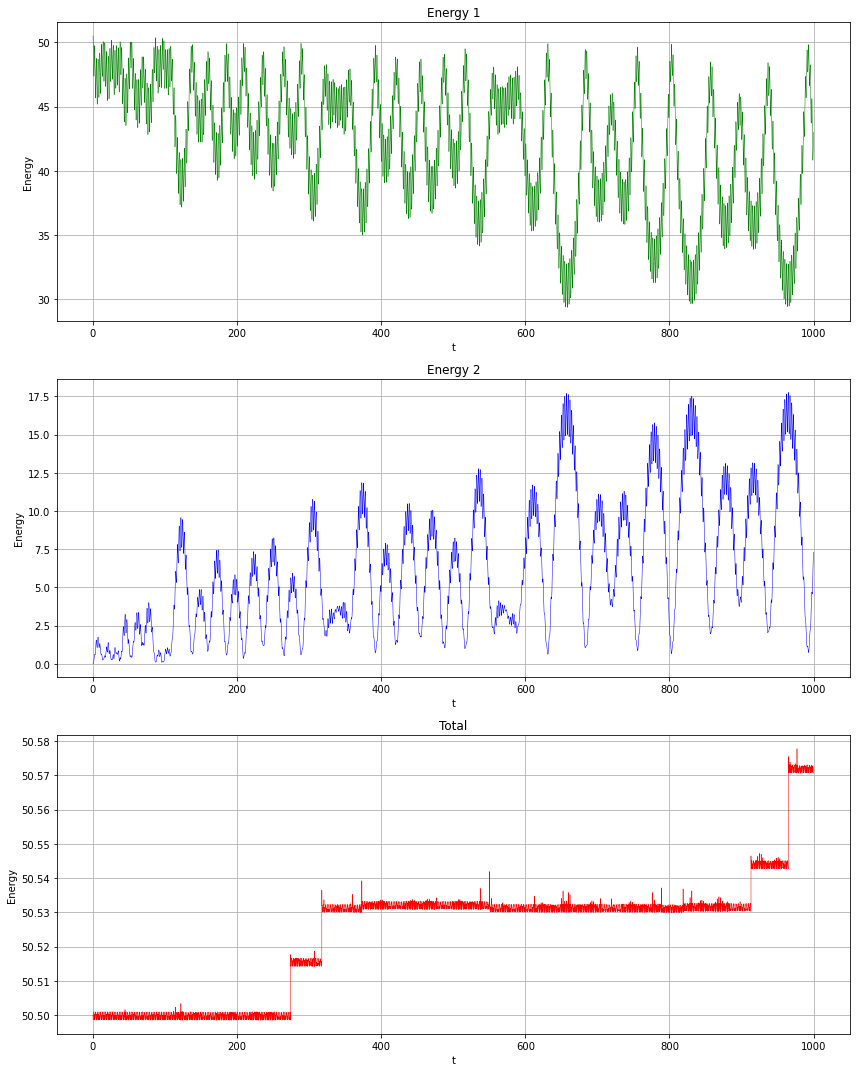

In [201]:

energy_1_vector, energy_2_vector, energy_coupling_vector = twin_energy_traj(e,w_1,w_2,twin_Q1, twin_Q2, twin_P1,twin_P2, "seperate")


indices = [i * h for i in range(len(energy_vector))]

# Create a figure with three subplots (1 row, 3 columns)
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Plot the first energy vector
axes[0].plot(indices, energy_1_vector, linestyle='-', color='g', linewidth=0.5)
axes[0].set_title('Energy 1')

# Plot the second energy vector
axes[1].plot(indices, energy_2_vector, linestyle='-', color='b', linewidth=0.5)
axes[1].set_title('Energy 2')

# Plot the third energy vector
axes[2].plot(indices, energy_coupling_vector, linestyle='-', color='r', linewidth=0.5)
axes[2].set_title('Total')

# Set common labels and adjust spacing
for ax in axes:
    ax.set_xlabel('t')
    ax.set_ylabel('Energy')
    ax.grid(True)

plt.tight_layout()  # Ensures proper spacing

# Display the plots
plt.show()

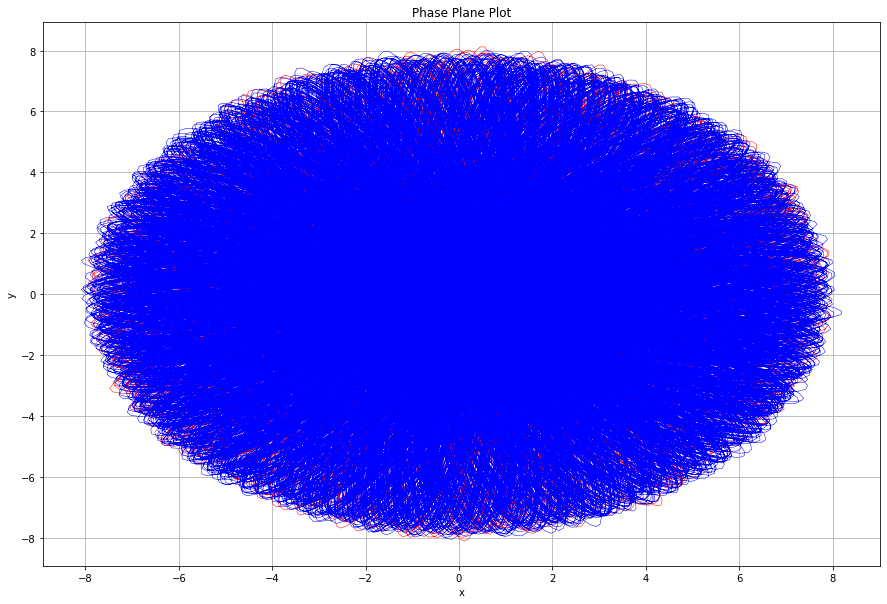

In [202]:
q1 = [0,-1]
q2 = [0,-1]
p1 = [10,1]
p2 = [0,0]
h = 0.1
N=100000
e = 0.1
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

# Get x and y positions from the matrix
x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

# Create a phase plane plot
plt.figure(figsize=(15, 10)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

# Display the plot
plt.show()


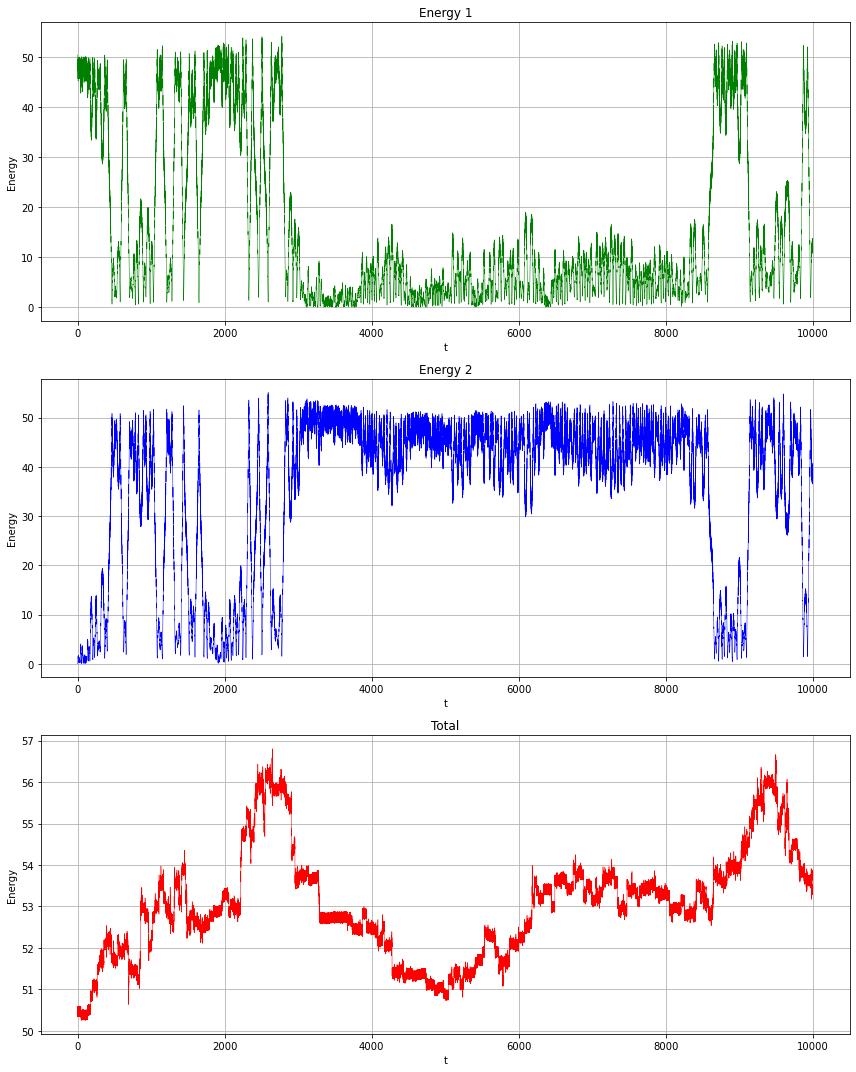

In [203]:
energy_1_vector, energy_2_vector, energy_coupling_vector = twin_energy_traj(e,w_1,w_2,twin_Q1, twin_Q2, twin_P1,twin_P2, "seperate")


indices = [i * h for i in range(len(energy_vector))]

# Create a figure with three subplots (1 row, 3 columns)
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Plot the first energy vector
axes[0].plot(indices, energy_1_vector, linestyle='-', color='g', linewidth=0.5)
axes[0].set_title('Energy 1')

# Plot the second energy vector
axes[1].plot(indices, energy_2_vector, linestyle='-', color='b', linewidth=0.5)
axes[1].set_title('Energy 2')

# Plot the third energy vector
axes[2].plot(indices, energy_coupling_vector, linestyle='-', color='r', linewidth=0.5)
axes[2].set_title('Total')

# Set common labels and adjust spacing
for ax in axes:
    ax.set_xlabel('t')
    ax.set_ylabel('Energy')
    ax.grid(True)

plt.tight_layout()  # Ensures proper spacing

# Display the plots
plt.show()

## *Comments:*
### **All else being equal, reducing the step size results in less energy conservation, which is apparent from the graphs. This is because the model is less accurate and constant first integral condition isn't satisfied for such inaccurate models.**

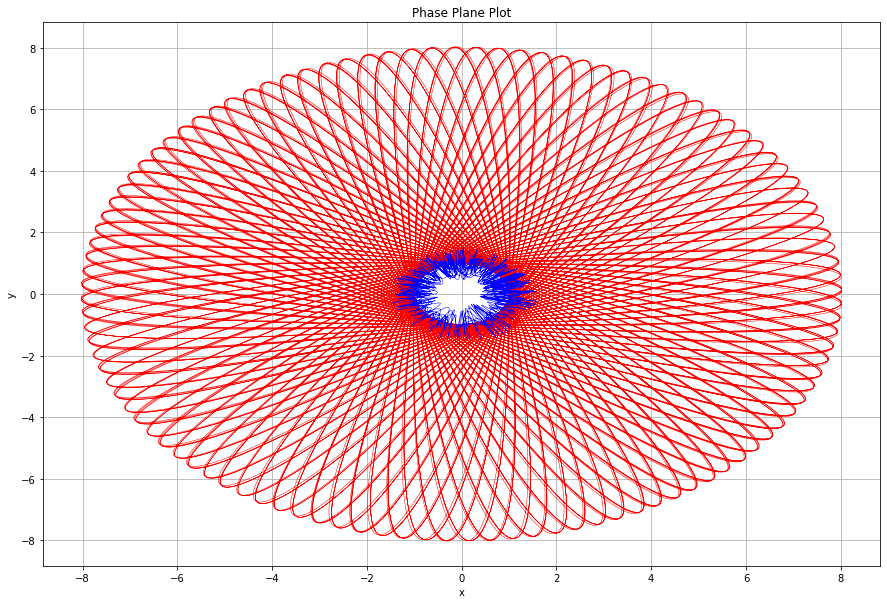

In [204]:
q1 = [0,-1]
q2 = [0,-1]
p1 = [10,1]
p2 = [0,0]
h = 0.01
N=100000
e = 0.01
w_1, w_2 = 1,1

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

# Get x and y positions from the matrix
x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

# Create a phase plane plot
plt.figure(figsize=(15, 10)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

# Display the plot
plt.show()

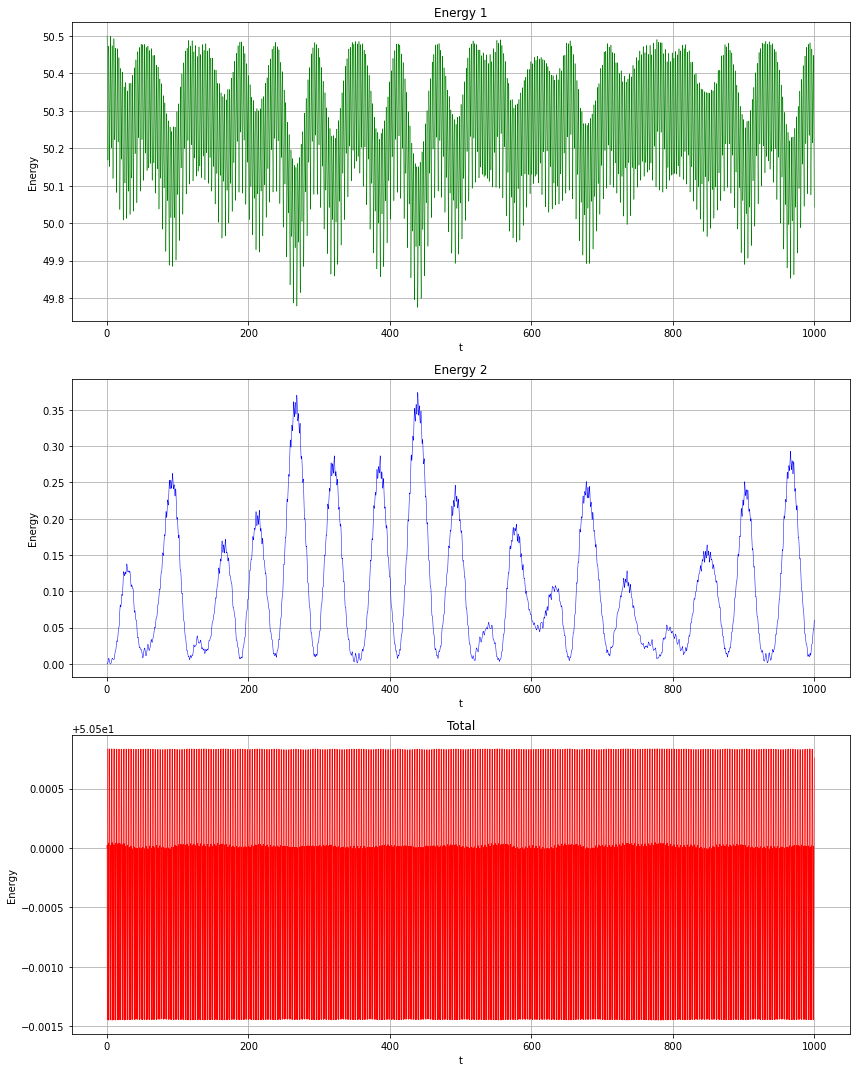

In [205]:
energy_1_vector, energy_2_vector, energy_coupling_vector = twin_energy_traj(e,w_1,w_2,twin_Q1, twin_Q2, twin_P1,twin_P2, "seperate")


indices = [i * h for i in range(len(energy_vector))]

# Create a figure with three subplots (1 row, 3 columns)
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Plot the first energy vector
axes[0].plot(indices, energy_1_vector, linestyle='-', color='g', linewidth=0.5)
axes[0].set_title('Energy 1')

# Plot the second energy vector
axes[1].plot(indices, energy_2_vector, linestyle='-', color='b', linewidth=0.5)
axes[1].set_title('Energy 2')

# Plot the third energy vector
axes[2].plot(indices, energy_coupling_vector, linestyle='-', color='r', linewidth=0.5)
axes[2].set_title('Total')

# Set common labels and adjust spacing
for ax in axes:
    ax.set_xlabel('t')
    ax.set_ylabel('Energy')
    ax.grid(True)

plt.tight_layout()  # Ensures proper spacing

# Display the plots
plt.show()

## *Comments:*
### **All else being equal, reducing the coupling coefficient bounds the movement of the particle that starts with lower energy and much of the energy is provided by the particle that starts with higher energy. So we may say that coupling coefficient is a factor that increases the energy transfer between particles.**

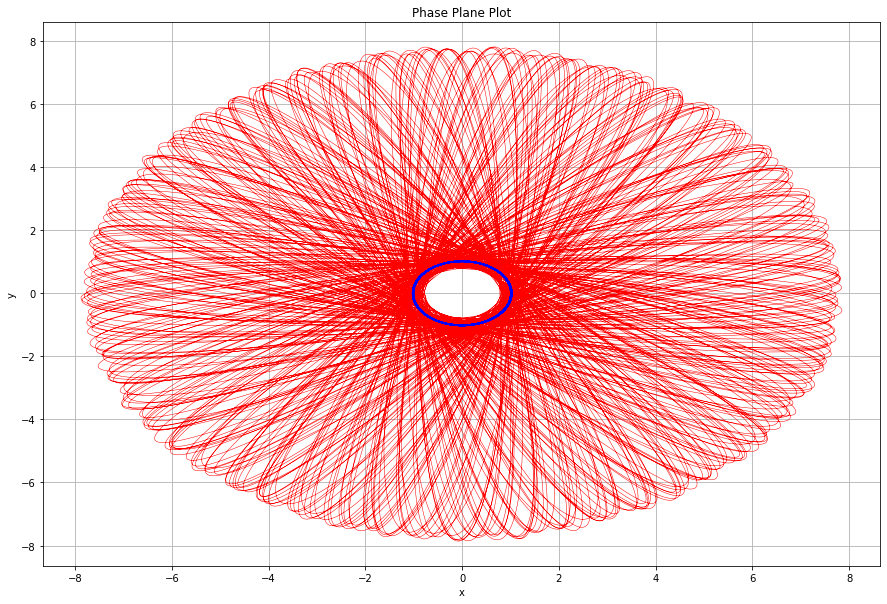

In [206]:
q1 = [0,-1]
q2 = [0,-1]
p1 = [10,1]
p2 = [0,0]
h = 0.01
N=100000
e = 0.1
w_1, w_2 = 1,10

twin_Q1, twin_Q2, twin_P1, twin_P2 = compute_trajectory_twin(w_1,w_2,e,h,N,q1,q2,p1,p2)

# Get x and y positions from the matrix
x1_positions = twin_Q1[0]
y1_positions = twin_Q1[1]

x2_positions = twin_Q2[0]
y2_positions = twin_Q2[1]

# Create a phase plane plot
plt.figure(figsize=(15, 10)) 
plt.plot(x1_positions, y1_positions, linestyle='-', color='r',linewidth=0.5)
plt.plot(x2_positions, y2_positions, linestyle='-', color='b',linewidth=0.5)
plt.title('Phase Plane Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

# Display the plot
plt.show()

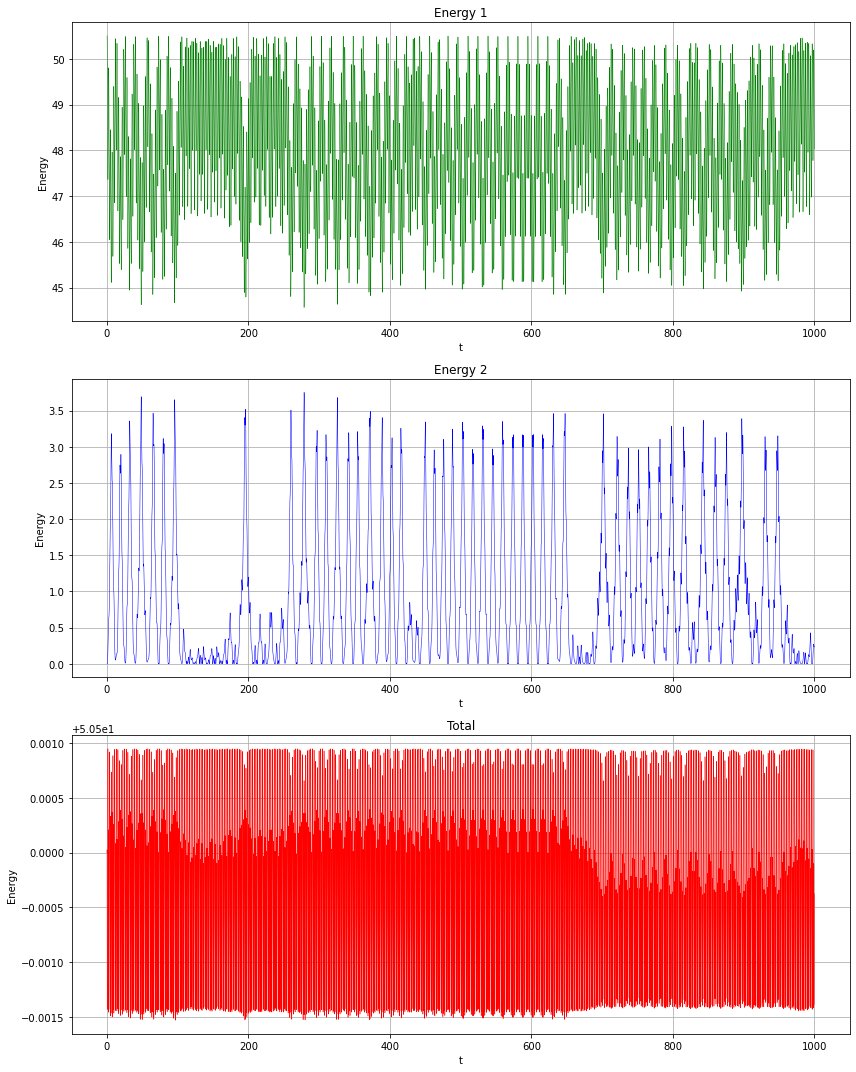

In [207]:
energy_1_vector, energy_2_vector, energy_coupling_vector = twin_energy_traj(e,w_1,w_2,twin_Q1, twin_Q2, twin_P1,twin_P2, "seperate")


indices = [i * h for i in range(len(energy_vector))]

# Create a figure with three subplots (1 row, 3 columns)
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Plot the first energy vector
axes[0].plot(indices, energy_1_vector, linestyle='-', color='g', linewidth=0.5)
axes[0].set_title('Energy 1')

# Plot the second energy vector
axes[1].plot(indices, energy_2_vector, linestyle='-', color='b', linewidth=0.5)
axes[1].set_title('Energy 2')

# Plot the third energy vector
axes[2].plot(indices, energy_coupling_vector, linestyle='-', color='r', linewidth=0.5)
axes[2].set_title('Total')

# Set common labels and adjust spacing
for ax in axes:
    ax.set_xlabel('t')
    ax.set_ylabel('Energy')
    ax.grid(True)

plt.tight_layout()  # Ensures proper spacing

# Display the plots
plt.show()

## *Comments:*
### **All else being equal, not synchronizing the angular frequency of the particles will result in less efficient exchange of energy and the one that has more energy will dominate the other, also hindering the movement of the other.**